# 2019320016 차주한

### Preprocess data using leammatizer

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load dataset and split into train & validation

In [2]:
import torch
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset

mail_field = data.Field(sequential=True, use_vocab=True, tokenize=str.split, lower=True, batch_first=True, fix_length=500)
label_field = data.Field(sequential=False, use_vocab=False, batch_first=False, is_target=True)
id_field = data.Field(sequential=False, use_vocab=False, batch_first=False, is_target=True)

loaded_data = TabularDataset(path="./data/train.csv",
                                 format="csv",
                                 fields=[("id" , id_field), ("label", label_field), ("mail", mail_field)],
                                 skip_header=True)

train_data, val_data = loaded_data.split(split_ratio=0.7, stratified=True, strata_field="label")

print("train data: ", len(train_data))
print(train_data.fields)
print("validation data: ", len(val_data))
print(val_data.fields)

train data:  2534
{'id': <torchtext.legacy.data.field.Field object at 0x000001D170B72C40>, 'label': <torchtext.legacy.data.field.Field object at 0x000001D16D4C8490>, 'mail': <torchtext.legacy.data.field.Field object at 0x000001D170B72C70>}
validation data:  1086
{'id': <torchtext.legacy.data.field.Field object at 0x000001D170B72C40>, 'label': <torchtext.legacy.data.field.Field object at 0x000001D16D4C8490>, 'mail': <torchtext.legacy.data.field.Field object at 0x000001D170B72C70>}


### Build vocabulary dictionary

In [3]:
from torchtext.vocab import GloVe

mail_field.build_vocab(train_data, vectors=GloVe(name="6B", dim=200), min_freq=1)
print("size of vocab: ", len(mail_field.vocab))
print("pretrained embedding vectors: ", mail_field.vocab.vectors.shape)
print(mail_field.vocab.stoi)

size of vocab:  34189
pretrained embedding vectors:  torch.Size([34189, 200])
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x000001D178730D90>>, {'<unk>': 0, '<pad>': 1, '-': 2, '.': 3, '/': 4, ',': 5, ':': 6, 'the': 7, 'to': 8, 'ect': 9, '@': 10, 'and': 11, 'for': 12, 'a': 13, 'of': 14, "'": 15, 'you': 16, 'hou': 17, 'in': 18, 'enron': 19, 'on': 20, 'this': 21, 'is': 22, ')': 23, ';': 24, '(': 25, '=': 26, 'i': 27, 'subject:': 28, 'be': 29, 'com': 30, 'that': 31, 'we': 32, '2000': 33, 'will': 34, 'from': 35, 'your': 36, 'with': 37, 'have': 38, '!': 39, '_': 40, 'at': 41, 's': 42, '>': 43, '?': 44, 'are': 45, 'it': 46, 'as': 47, 'please': 48, '"': 49, 'or': 50, 'if': 51, 'gas': 52, 'by': 53, 'not': 54, 'subject': 55, '1': 56, '$': 57, 'deal': 58, '3': 59, '#': 60, 'meter': 61, 'me': 62, 'am': 63, '2': 64, 'cc': 65, '00': 66, 'pm': 67, 'hpl': 68, '10': 69, 'e': 70, 'our': 71, '000': 72, 'any': 73, 'd': 74, 're': 75, 'corp': 76, 'can': 77,

### Make data loader

In [4]:
from torchtext.legacy.data import Iterator

batch_size = 256
train_loader = Iterator(dataset=train_data, batch_size=batch_size, device="cuda")
val_loader = Iterator(dataset=val_data, batch_size=len(val_data), device="cuda", shuffle=False)

### Make recurrent net model

In [5]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, n_layers, hidden_size, dropout):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(mail_field.vocab.vectors, freeze=True, padding_idx=1)
        self.rnn = nn.GRU(num_layers=n_layers,input_size=mail_field.vocab.vectors.shape[1] ,hidden_size=hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(hidden_size ,1)

    def forward(self, x):
        embedded = self.embedding(x)
        h, _ = self.rnn(embedded)
        h_t = h[:, -1, :]
        activation = self.relu(h_t)
        dropped = self.dropout(activation)
        logit = self.linear(dropped)
        return logit.squeeze()

### Train & evaluate function

In [6]:
def train(model, loss_fn, optimizer, loader):
    model.train()
    for batch in loader:
        x, y = batch.mail, batch.label
        optimizer.zero_grad()

        logit = model(x)
        loss = loss_fn(logit, y.float())
        loss.backward()

        optimizer.step()

def evaluate(model, loss_fn, loader):
    model.eval()
    total_loss, corrects = 0, 0

    for batch in loader:
        x,y = batch.mail, batch.label

        logit = model(x)
        loss = loss_fn(logit, y.float())
        total_loss += loss.item()

        predicted = (logit > 0) * 1
        corrects += (predicted == y).sum()

    size = len(loader.dataset)
    avg_loss = total_loss / size
    avg_accuracy = corrects / size

    return avg_loss, avg_accuracy

In [7]:
best_val_acc = 0
best_model_train_acc = 0
best_model = None
best_model_history = None
best_model_hyperparameter = {}

In [8]:
import copy

def train_model_with_hyperparameter(lr, dropout, reg, hidden_size):
    global best_val_acc
    global best_model_train_acc
    global best_model
    global best_model_history
    global best_model_hyperparameter

    train_history = []
    val_history = []

    model = MyModel(n_layers=1, hidden_size=hidden_size, dropout=dropout).to("cuda")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction="sum").to("cuda")

    for e in range(30):
        train(model, loss_fn, optimizer, train_loader)
        train_loss, train_accuracy = evaluate(model, loss_fn, train_loader)
        val_loss, val_accuracy = evaluate(model, loss_fn, val_loader)

        train_history.append(train_accuracy.cpu().item())
        val_history.append(val_accuracy.cpu().item())

        print("[Epoch: %2d] train loss: %5.4f | train accuracy: %5.4f | val loss: %5.4f | val accuracy: %5.4f" % (e + 1, train_loss, train_accuracy, val_loss, val_accuracy))

        if  val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_train_acc = train_accuracy
            best_model = copy.deepcopy(model)
            best_model_history = (train_history, val_history)
            best_model_hyperparameter = {"lr": lr, "dropout": dropout, "reg": reg, "hidden_size": hidden_size}

### Train model with random hyperparameters

In [9]:
import numpy as np

for i in range(5):
    lr = np.random.uniform(6e-3, 8e-3)
    dropout = np.random.uniform(0.5, 0.8)
    reg = np.random.uniform(8e-4, 1e-3)
    hidden_size = np.random.randint(8, 9)

    print("lr: %e / dropout: %f / reg: %e / hidden size: %d" %(lr, dropout, reg, 2 ** hidden_size))
    train_model_with_hyperparameter(lr, dropout, reg, 2 ** hidden_size)
    print()

print("Best model validation accuracy: ", best_val_acc)
print("Best model train accuracy: ", best_model_train_acc)
print("Best model hyper parameters")
print("lr %e: " % (best_model_hyperparameter["lr"]))
print("dropout: ", best_model_hyperparameter["dropout"])
print("reg %e: " % (best_model_hyperparameter["reg"]))
print("hidden size:", best_model_hyperparameter["hidden_size"])

lr: 7.307292e-03 / dropout: 0.717611 / reg: 9.836203e-04 / hidden size: 256
[Epoch:  1] train loss: 0.5954 | train accuracy: 0.7151 | val loss: 0.5916 | val accuracy: 0.7155
[Epoch:  2] train loss: 0.5849 | train accuracy: 0.7249 | val loss: 0.5991 | val accuracy: 0.6998
[Epoch:  3] train loss: 0.5699 | train accuracy: 0.7368 | val loss: 0.5850 | val accuracy: 0.7182
[Epoch:  4] train loss: 0.4839 | train accuracy: 0.7486 | val loss: 0.5537 | val accuracy: 0.7339
[Epoch:  5] train loss: 0.4077 | train accuracy: 0.8520 | val loss: 0.4694 | val accuracy: 0.8306
[Epoch:  6] train loss: 0.6495 | train accuracy: 0.7151 | val loss: 0.6554 | val accuracy: 0.7155
[Epoch:  7] train loss: 0.5140 | train accuracy: 0.7356 | val loss: 0.5255 | val accuracy: 0.7210
[Epoch:  8] train loss: 0.3772 | train accuracy: 0.8611 | val loss: 0.3911 | val accuracy: 0.8462
[Epoch:  9] train loss: 0.2570 | train accuracy: 0.8982 | val loss: 0.2877 | val accuracy: 0.8794
[Epoch: 10] train loss: 0.1715 | train acc

### Visualize GRU train history

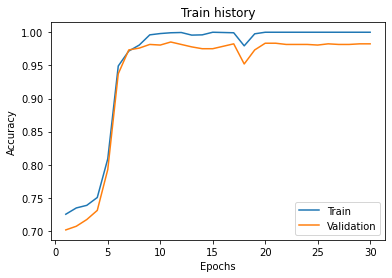

In [10]:
from matplotlib import pyplot as plt
epochs = list(range(1, 31))

plt.plot(epochs, best_model_history[0])
plt.plot(epochs, best_model_history[1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train history")
plt.legend(["Train", "Validation"])
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

def print_performance(y, y_predict):
    ConfusionMatrixDisplay.from_predictions(y, y_predict)
    plt.show()

    print("accuracy: ", accuracy_score(y, y_predict))
    print("precision: ", precision_score(y, y_predict))
    print("recall: ", recall_score(y, y_predict))
    print("f1: ", f1_score(y, y_predict))

### Performance of GRU model on train set

C:\Users\hanchaa\anaconda3\envs\COSE362\lib\site-packages\torch\nn\modules\rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


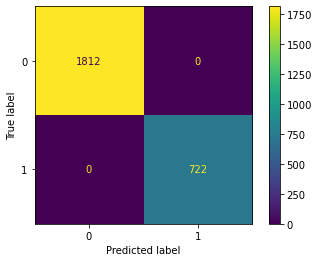

accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0


In [12]:
y_train = torch.LongTensor([])
gru_train_result = torch.LongTensor([])

for batch in train_loader:
    x = batch.mail
    y = batch.label.cpu()

    logit = best_model(x)
    gru_result = ((logit >= 0) * 1).cpu()

    y_train = torch.concat([y_train, y])
    gru_train_result = torch.concat([gru_train_result, y])

print_performance(y_train, gru_train_result)

### Performance of GRU model on validation set

C:\Users\hanchaa\anaconda3\envs\COSE362\lib\site-packages\torch\nn\modules\rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


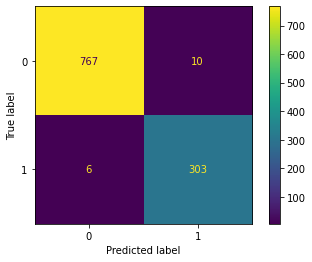

accuracy:  0.9852670349907919
precision:  0.9680511182108626
recall:  0.9805825242718447
f1:  0.9742765273311897


In [13]:
for batch in val_loader:
    x = batch.mail
    y = batch.label.cpu()

    logit = best_model(x)
    gru_val_result = ((logit >= 0) * 1).cpu().numpy()

print_performance(y, gru_val_result)

### Prepare datas for naive bayse

In [12]:
import numpy as np

X_train = []
y_train = []
X_val = []
y_val = []

for i in train_data:
    X_train.append(" ".join(i.mail))
    y_train.append(i.label)

for i in val_data:
    X_val.append(" ".join(i.mail))
    y_val.append(i.label)

X_train = np.array(X_train)
y_train = np.array(y_train).astype(int)
X_val = np.array(X_val)
y_val = np.array(y_val).astype(int)

print(vars(train_data[0]))
print("label: ", y_train[0], ", mail: ", X_train[0])

print(vars(val_data[0]))
print("label: ", y_val[0], ", mail: ", X_val[0])

{'id': '1102', 'label': '1', 'mail': ['subject:', 'business', 'ideas', ':', 'march', '2005', 'hows', 'it', 'going', 'looking', 'for', 'a', 'new', 'way', 'to', 'generate', 'income', 'easily', 'with', 'the', 'explosion', 'of', 'the', 'online', 'world', 'come', 'new', 'opportunities', 'you', 'no', 'longer', 'need', 'tons', 'of', 'cash', 'to', 'reach', 'a', 'large', 'audience', 'you', 'can', 'run', 'an', 'online', 'casiino', 'from', 'your', 'home', 'nothing', 'fancy', 'is', 'needed', ',', 'just', 'a', 'computer', 'and', 'a', 'little', 'money', 'down', 'telephone', '1', '-', '877', '-', '800', '-', '5085', 'extention', '315', 'to', 'get', 'set', 'up', 'chapel', 'vampire', 'altruism', 'bunk', 'sagacity']}
label:  1 , mail:  subject: business ideas : march 2005 hows it going looking for a new way to generate income easily with the explosion of the online world come new opportunities you no longer need tons of cash to reach a large audience you can run an online casiino from your home nothing 

### Make word of bag and transform to feature vector

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=str.split, min_df=1)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

print("subject dtm shape: " + str(X_train_vectorized.shape))

subject dtm shape: (2534, 34187)


### Train Naive Bayse

In [14]:
from sklearn.naive_bayes import MultinomialNB

best_nb_model = None
best_nb_val_acc = 0
train_acc_history = []
val_acc_history = []
alphas = [2, 1.75, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001]

for alpha in alphas:
    NB_model = MultinomialNB(alpha=alpha)
    NB_model.fit(X_train_vectorized, y_train)

    train_acc = accuracy_score(y_train, NB_model.predict(X_train_vectorized))
    val_acc = accuracy_score(y_val, NB_model.predict(X_val_vectorized))

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print("alpha: %f / train acc: %f / val acc: %f" % (alpha, train_acc, val_acc))

    if val_acc > best_nb_val_acc:
        best_nb_val_acc = val_acc
        best_nb_model = copy.deepcopy(NB_model)

alpha: 2.000000 / train acc: 0.980663 / val acc: 0.967772
alpha: 1.750000 / train acc: 0.981452 / val acc: 0.967772
alpha: 1.500000 / train acc: 0.982242 / val acc: 0.970534
alpha: 1.250000 / train acc: 0.983820 / val acc: 0.971455
alpha: 1.000000 / train acc: 0.985004 / val acc: 0.973297
alpha: 0.750000 / train acc: 0.986582 / val acc: 0.971455
alpha: 0.500000 / train acc: 0.986977 / val acc: 0.974217
alpha: 0.250000 / train acc: 0.988950 / val acc: 0.974217
alpha: 0.100000 / train acc: 0.988950 / val acc: 0.976059
alpha: 0.075000 / train acc: 0.989345 / val acc: 0.976059
alpha: 0.050000 / train acc: 0.990134 / val acc: 0.977901
alpha: 0.025000 / train acc: 0.990529 / val acc: 0.976980
alpha: 0.010000 / train acc: 0.990923 / val acc: 0.977901
alpha: 0.007500 / train acc: 0.991318 / val acc: 0.977901
alpha: 0.005000 / train acc: 0.991318 / val acc: 0.976980
alpha: 0.002500 / train acc: 0.991318 / val acc: 0.976059
alpha: 0.001000 / train acc: 0.992107 / val acc: 0.976059


### Plot NB accuracy change upon hyperparameter

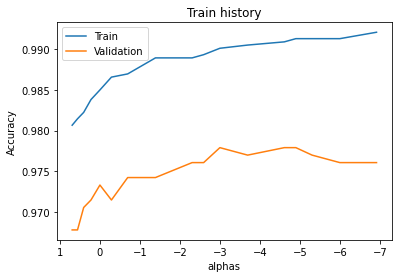

In [15]:
from matplotlib import pyplot as plt

plt.plot(np.log(alphas), train_acc_history)
plt.plot(np.log(alphas), val_acc_history)
plt.gca().invert_xaxis()
plt.xlabel("alphas")
plt.ylabel("Accuracy")
plt.title("Train history")
plt.legend(["Train", "Validation"])
plt.show()

### Performance of the best NB model on train set

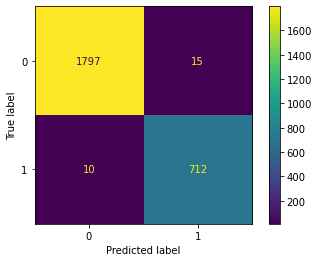

accuracy:  0.9901341752170482
precision:  0.9793672627235214
recall:  0.9861495844875346
f1:  0.9827467218771567


In [16]:
nb_train_result = best_nb_model.predict(X_train_vectorized)
print_performance(y_train, nb_train_result)

### Performance of the best NB model on validation set

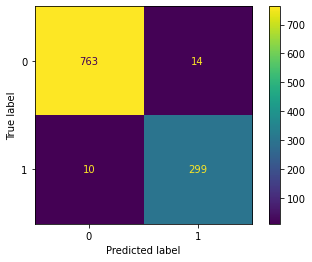

accuracy:  0.9779005524861878
precision:  0.9552715654952076
recall:  0.9676375404530745
f1:  0.9614147909967845


In [17]:
nb_val_result = best_nb_model.predict(X_val_vectorized)
print_performance(y_val, nb_val_result)

### Train SVM

In [19]:
from sklearn.svm import SVC

best_svm_model = None
best_svm_val_acc = 0
train_acc_history = []
val_acc_history = []
cs = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for c in cs:
    SVM_model = SVC(kernel="linear", C=c, probability=True)
    SVM_model.fit(X_train_vectorized, y_train)

    train_acc = accuracy_score(y_train, SVM_model.predict(X_train_vectorized))
    val_acc = accuracy_score(y_val, SVM_model.predict(X_val_vectorized))

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print("c: %f / train acc: %f / val acc: %f" % (c, train_acc, val_acc))

    if val_acc > best_svm_val_acc:
        best_svm_val_acc = val_acc
        best_svm_model = copy.deepcopy(SVM_model)

c: 0.010000 / train acc: 0.990134 / val acc: 0.968692
c: 0.025000 / train acc: 0.994870 / val acc: 0.965930
c: 0.050000 / train acc: 0.998027 / val acc: 0.972376
c: 0.075000 / train acc: 0.998421 / val acc: 0.972376
c: 0.100000 / train acc: 0.998816 / val acc: 0.972376
c: 0.250000 / train acc: 1.000000 / val acc: 0.974217
c: 0.500000 / train acc: 1.000000 / val acc: 0.971455
c: 0.750000 / train acc: 1.000000 / val acc: 0.968692
c: 1.000000 / train acc: 1.000000 / val acc: 0.968692


### Plot SVM accuracy change upon hyperparameter

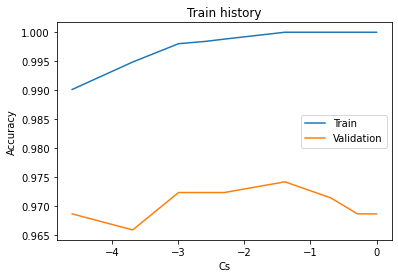

In [20]:
from matplotlib import pyplot as plt

plt.plot(np.log(cs), train_acc_history)
plt.plot(np.log(cs), val_acc_history)
plt.xlabel("Cs")
plt.ylabel("Accuracy")
plt.title("Train history")
plt.legend(["Train", "Validation"])
plt.show()

### Performance of the best SVM model on train set

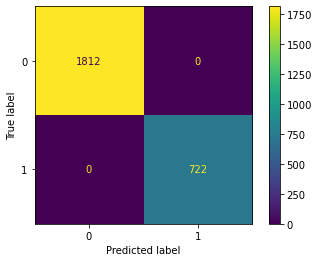

accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0


In [21]:
svm_train_result = best_svm_model.predict(X_train_vectorized)
print_performance(y_train, svm_train_result)

### Performance of the best SVM model on validation set

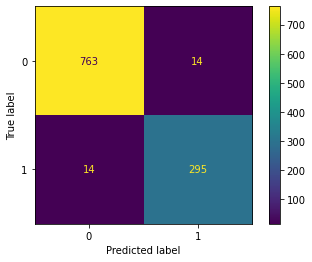

accuracy:  0.9742173112338858
precision:  0.9546925566343042
recall:  0.9546925566343042
f1:  0.9546925566343042


In [22]:
svm_val_result = best_svm_model.predict(X_val_vectorized)

print_performance(y_val, svm_val_result)

### Performance of ensemble model on train data

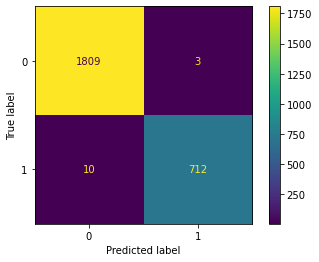

accuracy:  0.994869771112865
precision:  0.9958041958041958
recall:  0.9861495844875346
f1:  0.9909533750869868


In [28]:
ensembled_train_result = ((gru_train_result + nb_train_result + svm_train_result) >= 2) * 1
print_performance(y_train, ensembled_train_result)

### Performance of ensemble model on validation data

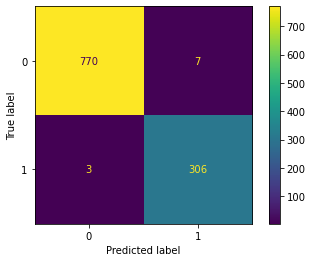

accuracy:  0.990791896869245
precision:  0.9776357827476039
recall:  0.9902912621359223
f1:  0.9839228295819936


In [29]:
ensembled_val_result = ((gru_val_result + nb_val_result + svm_val_result) >= 2) * 1
print_performance(y_val, ensembled_val_result)

### Predict on test data

In [30]:
test_data = TabularDataset(path="./data/test.csv",
                                 format="csv",
                                 fields=[("id" , id_field), ("mail", mail_field)],
                                 skip_header=True)

test_loader = Iterator(dataset=test_data, batch_size=len(test_data), device="cuda", shuffle=False)

best_model.eval()

for batch in test_loader:
    x = batch.mail
    id = batch.id

    print(id)

    logit = best_model(x)
    gru_test_result = ((logit >= 0) * 1).cpu().numpy()

X_test = []

for i in test_data:
    X_test.append(" ".join(i.mail))

X_test_vectorized = vectorizer.transform(X_test)
nb_test_result = NB_model.predict(X_test_vectorized)
svm_test_result = SVM_model.predict(X_test_vectorized)

ensembled_predicted = ((gru_test_result + nb_test_result + svm_test_result) >= 2) * 1

print(ensembled_predicted)

tensor([   0,    1,    2,  ..., 1548, 1549, 1550], device='cuda:0')


C:\Users\hanchaa\anaconda3\envs\COSE362\lib\site-packages\torch\nn\modules\rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


[0 0 0 ... 1 0 0]


In [31]:
import csv

f = open("result.csv", "w", newline="")
wr = csv.writer(f)
wr.writerow(["id", "label"])

id = 0
for i in ensembled_predicted:
    wr.writerow([id, i])
    id += 1

f.close()